**Note**: This notebook was executed on Kaggle due to the lack of local computational resources.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import os
import sys

sys.path.append(os.path.join(os.getcwd(), '..', 'input', 'unet-model'))
sys.path.append(os.path.join(os.getcwd(), '..', 'input', 'road-segmentation-data-loader'))

from unet import *
from load_data import *

# %load_ext autoreload
# %autoreload 2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 0. Read in images, preprocess and create an augmented dataset

In [2]:
print(tf.version.VERSION)
print(tf.config.list_physical_devices('GPU'))

# Prevent automatic GPU memory pre-allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

2.13.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
# Read in images from directory and create tf.data.Dataset
# Get file names
imgs_dir = os.path.join(os.path.dirname(os.getcwd()), 'input', 'road-segmentation-ds', 'training', 'images')
gts_dir = os.path.join(os.path.dirname(os.getcwd()), 'input', 'road-segmentation-ds', 'training', 'groundtruth')

# Since using iou loss, need to one hot encode the groundtruth images
original_dataset = create_dataset(imgs_dir, gts_dir, one_hot = False)

print(f'Loaded data set: {original_dataset}')

Loaded data set: <_MapDataset element_spec=(TensorSpec(shape=(400, 400, 3), dtype=tf.float32, name=None), TensorSpec(shape=(400, 400, 1), dtype=tf.float32, name=None))>


In [4]:
# Split into train and validation split
# Augmentation is only performed on the training split

# Shuffle the dataset
# Seed of 1 for reproducibility
train_prop = 0.9
num_samples = len(original_dataset)

# seed and reshuffle_each_iteration = False to prevent reshuffling after each iteration of dataset for reproducibility
seed = 1
shuffled_dataset = original_dataset.shuffle(buffer_size = num_samples, seed = seed, reshuffle_each_iteration = False)  
print(f'Shuffled data set: {shuffled_dataset}, no. of samples: {len(shuffled_dataset)}')

train_size = int(train_prop*num_samples)
train_dataset = shuffled_dataset.take(train_size)
val_dataset = shuffled_dataset.skip(train_size)
print(f'Train data set: {train_dataset}, no.of samples: {len(train_dataset)}')
print(f'Validation data set: {val_dataset}, no.of samples: {len(val_dataset)}')

Shuffled data set: <_ShuffleDataset element_spec=(TensorSpec(shape=(400, 400, 3), dtype=tf.float32, name=None), TensorSpec(shape=(400, 400, 1), dtype=tf.float32, name=None))>, no. of samples: 100
Train data set: <_TakeDataset element_spec=(TensorSpec(shape=(400, 400, 3), dtype=tf.float32, name=None), TensorSpec(shape=(400, 400, 1), dtype=tf.float32, name=None))>, no.of samples: 90
Validation data set: <_SkipDataset element_spec=(TensorSpec(shape=(400, 400, 3), dtype=tf.float32, name=None), TensorSpec(shape=(400, 400, 1), dtype=tf.float32, name=None))>, no.of samples: 10


In [5]:
# Change flag to run test on augmented or original dataset
augment_dataset = False

In [6]:
if augment_dataset:
    
    # Augment the train split
    print(f'Original train dataset: {train_dataset}')
    print(f'No. of samples before augmenting: {len(train_dataset)}')

    num_images = [2, 1, 3] # [num_brightness, num_rotation, num_noise]
    augmented_train_dataset = create_augmented_dataset(train_dataset, num_images)

    print(f'Augmented train dataset: {augmented_train_dataset}')
    print(f'No. of samples after augmenting: {len(augmented_train_dataset)}')
    
    # Split augmented train dataset into train and validation. These validations will be used to validate the model while the
    # validation dataset obtained prior to augmenting the dataset will be used to test the model
    num_samples = len(augmented_train_dataset)
    train_prop = 0.9
    train_size = int(train_prop*num_samples)
    augmented_tr_dataset = augmented_train_dataset.take(train_size)
    augmented_val_dataset = augmented_train_dataset.skip(train_size)

    print(f'No. of samples in augmented train dataset: {len(augmented_tr_dataset)}')
    print(f'No. of samples in augmented validation dataset: {len(augmented_val_dataset)}')

    # Batch the dataset
    augmented_tr_dataset = augmented_tr_dataset.batch(8)
    augmented_val_dataset = augmented_val_dataset.batch(8)

    # Seperate the dataset into train and validation
    batched_train_imgs_ds = augmented_tr_dataset.map(lambda img, gt: img)
    batched_train_gts_ds = augmented_tr_dataset.map(lambda img, gt: gt)
    batched_val_imgs_ds = augmented_val_dataset.map(lambda img, gt: img)
    batched_val_gts_ds = augmented_val_dataset.map(lambda img, gt: gt)

else:
    
    batched_train_dataset = train_dataset.batch(8)
    batched_val_dataset = val_dataset.batch(10)

    # Seperate the dataset into train and validation
    batched_train_imgs_ds = batched_train_dataset.map(lambda img, gt: img)
    batched_train_gts_ds = batched_train_dataset.map(lambda img, gt: gt)
    batched_val_imgs_ds = batched_val_dataset.map(lambda img, gt: img)
    batched_val_gts_ds = batched_val_dataset.map(lambda img, gt: gt)

In [7]:
# Make a list out of the batched dataset to be used in model training later
train_imgs = list(iter(batched_train_imgs_ds))
train_gts = list(iter(batched_train_gts_ds))
val_imgs = list(iter(batched_val_imgs_ds))
val_gts = list(iter(batched_val_gts_ds))

print(f'No. of training batches: {len(train_imgs)}')
print(f'No. of validation batches: {len(val_imgs)}')

No. of training batches: 12
No. of validation batches: 1


In [8]:
# Determine class weights which will be used in model later on
road_pixel_prop, bg_pixel_prop = get_class_weights(imgs_dir, gts_dir)
print(f'Road pixel proportions: {road_pixel_prop}, Background pixel proportions: {bg_pixel_prop}')

road_weight = 1./road_pixel_prop
bg_weight = 1./bg_pixel_prop
print(f'Road weight: {road_weight}, Background weight: {bg_weight}')

Road pixel proportions: 0.22525987499999997, Background pixel proportions: 0.7747401249999997
Road weight: 4.439317033271017, Background weight: 1.2907554000768973


# 1. Instantiate model and train model

In [9]:
RE_TRAIN = True

In [10]:
# Write training loop for model
if RE_TRAIN:
    
    # Hyperparameters
    num_epochs = 100 # 100
    generate_every = 25 # 25
    lr = 0.0001

    # Arrays to store results
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    train_ious = []
    val_ious = []
    train_dices = []
    val_dices = []

    # Keep track of which validation batch is used at each epoch
    num_val_batches = len(val_imgs)
    val_batch_idx = 0
    
    # Instantiate model
    img_height = 400
    img_width = 400
    num_channels = 3
    input_shape = (None, img_height, img_width, num_channels)
    unet_model = UNet(input_shape, bg_weight, road_weight)
     
    # Define optimiser
    optimiser = tf.keras.optimizers.Adam(learning_rate = lr)
    unet_model.compile(optimizer = optimiser)

    # Start training loop
    for epoch in range(num_epochs):

        print(f'Start of epoch {epoch}.')
        for batch_no, train_imgs_batch in enumerate(train_imgs):

            with tf.GradientTape() as tape:

                # Pass images into model and get prediction
                train_outputs = unet_model(train_imgs[batch_no])

                # Calculate loss
                train_loss = unet_model.compute_loss(train_gts[batch_no], train_outputs)

            # Compute and apply gradients
            grads = tape.gradient(train_loss, unet_model.trainable_weights)
            grads = [tf.clip_by_value(grad, -5.0, 5.0) if grad is not None else None for grad in grads]
            optimiser.apply_gradients(zip(grads, unet_model.trainable_weights))

        # Calculate on validation set
        val_outputs = unet_model(val_imgs[val_batch_idx]) # only one batch for validation
        val_loss = unet_model.compute_loss(val_gts[val_batch_idx], val_outputs)

        # Compute metrics
        train_acc, train_iou, train_dice = unet_model.compute_metrics(train_gts[batch_no], train_outputs)
        val_acc, val_iou, val_dice = unet_model.compute_metrics(val_gts[val_batch_idx], val_outputs)
        
        
        # Save results
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        train_ious.append(train_iou)
        train_dices.append(train_dice)

        val_losses.append(val_loss)
        val_accs.append(val_acc)
        val_ious.append(val_iou)
        val_dices.append(val_dice)
        
        # Increase validation batch index
        val_batch_idx += 1
        if val_batch_idx > 0 and val_batch_idx % num_val_batches == 0:
            val_batch_idx = 0
            
        print(f'tr_Loss: {train_loss}, tr_acc: {train_acc}, tr_iou: {train_iou}, tr_dice: {train_dice}')
        print(f'val_Loss: {val_loss}, val_acc: {val_acc}, val_iou: {val_iou}, val_dice: {val_dice}')

        # Generate the segmentation map and save it every 'generate_every' epochs
        if (epoch + 1) % generate_every == 0 and epoch > 0:
            np.save(f'train_epoch_{epoch + 1}', train_outputs[0]) 
    
    # Save trained weights
    unet_model.save_weights('unet_bceweights.h5')

else:
    
    unet_model.load_weights('unet_bceweights.h5')

Start of epoch 0.
tr_Loss: 1.656494140625, tr_acc: 0.7681468725204468, tr_iou: 0.12314847856760025, tr_dice: 0.2192915380001068
val_Loss: 1.4153006076812744, val_acc: 0.8109156489372253, val_iou: 0.12370558828115463, val_dice: 0.2201743721961975
Start of epoch 1.
tr_Loss: 1.594265341758728, tr_acc: 0.7689999938011169, tr_iou: 0.12663544714450836, tr_dice: 0.2248028814792633
val_Loss: 1.3688836097717285, val_acc: 0.8115737438201904, val_iou: 0.1257520169019699, val_dice: 0.22340981662273407
Start of epoch 2.
tr_Loss: 1.4456102848052979, tr_acc: 0.7689843773841858, tr_iou: 0.15343138575553894, tr_dice: 0.26604336500167847
val_Loss: 1.3050721883773804, val_acc: 0.8115112781524658, val_iou: 0.1378946155309677, val_dice: 0.24236799776554108
Start of epoch 3.
tr_Loss: 1.3635661602020264, tr_acc: 0.7691656351089478, tr_iou: 0.18458077311515808, tr_dice: 0.3116389811038971
val_Loss: 1.2777637243270874, val_acc: 0.8116068840026855, val_iou: 0.14429111778736115, val_dice: 0.25219303369522095
Sta

# 2. Evaluation

In this section, we would evaluate the output of the model via the following analysis.

1. Training curves of loss and key metrics
2. Visualisation of segmentation map at every 25th epoch
3. Comparison of predicted segmentation map with groundtruth segmentation map

## 2.1 Evaluation metrics and loss

<Figure size 2000x1000 with 0 Axes>

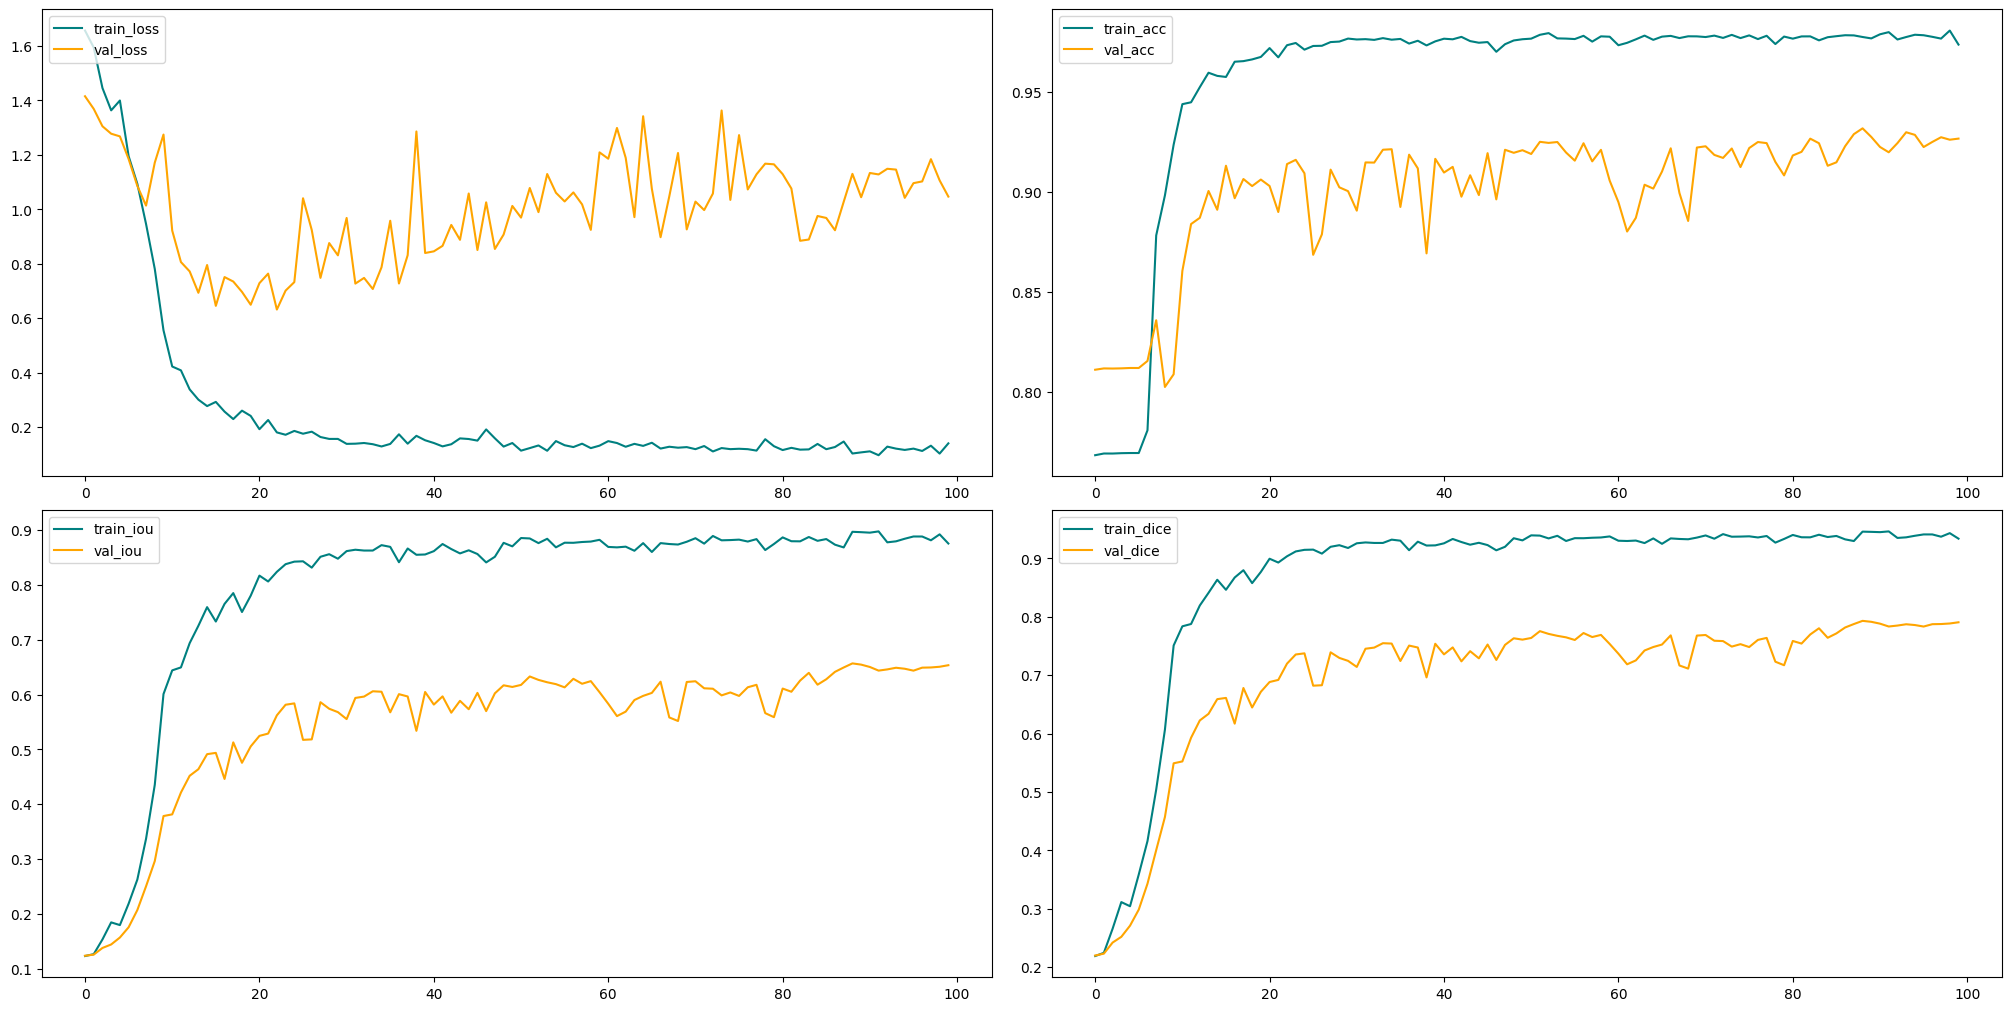

In [11]:
plt.rcParams['figure.figsize'] = [20, 10]
figure = plt.figure(figsize=(20,10))
fig, axs = plt.subplots(2, 2, constrained_layout = True)
epochs = [_ for _ in range(len(train_losses))]

axs[0][0].plot(epochs, train_losses, color='teal', label='train_loss')
axs[0][0].plot(epochs, val_losses, color='orange', label='val_loss')
axs[0][0].legend(loc='upper left')

axs[0][1].plot(epochs, train_accs, color='teal', label='train_acc')
axs[0][1].plot(epochs, val_accs, color='orange', label='val_acc')
axs[0][1].legend(loc='upper left')

axs[1][0].plot(epochs, train_ious, color='teal', label='train_iou')
axs[1][0].plot(epochs, val_ious, color='orange', label='val_iou')
axs[1][0].legend(loc='upper left')

axs[1][1].plot(epochs, train_dices, color='teal', label='train_dice')
axs[1][1].plot(epochs, val_dices, color='orange', label='val_dice')
axs[1][1].legend(loc='upper left')

## 2.2 Visualisation of segmentation map

In [12]:
def output_to_segmap(output_nparray, threshold = 0.5):
    
    """Converts model's output, a numpy array, into a segmentation map 
    
    Args:
        output_nparray: numpy array, model's output
        threshold: float, scalar to threshold predicted probability
    Returns:
        output_segmap: numpy array, segmentation map of model's output
    """
    
    output_segmap = np.where(output_nparray > 0.5, 1., 0.)
    output_segmap = output_segmap*255.
    return output_segmap

Text(0.5, 1.0, 'Epoch 80')

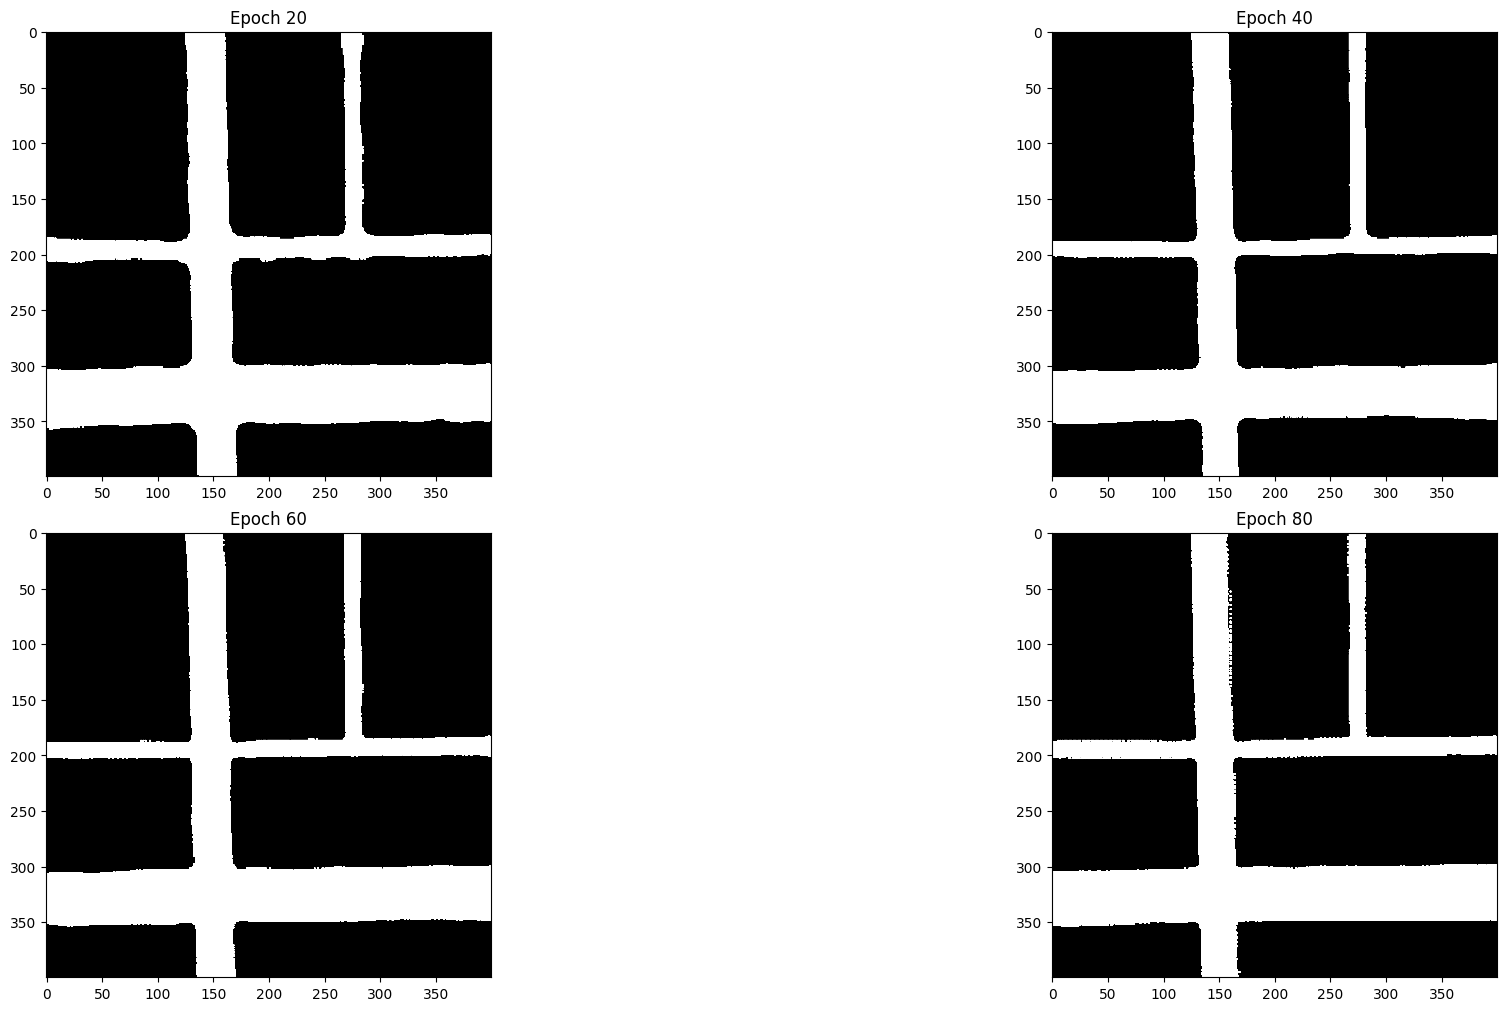

In [13]:
fig, axs = plt.subplots(2, 2, constrained_layout = True)

axs[0][0].imshow(output_to_segmap(np.load('train_epoch_25.npy')), cmap='gray', vmin = 0, vmax = 1)
axs[0][0].set_title('Epoch 20')

axs[0][1].imshow(output_to_segmap(np.load('train_epoch_50.npy')), cmap='gray', vmin = 0, vmax = 1)
axs[0][1].set_title('Epoch 40')

axs[1][0].imshow(output_to_segmap(np.load('train_epoch_75.npy')), cmap='gray', vmin = 0, vmax = 1)
axs[1][0].set_title('Epoch 60')

axs[1][1].imshow(output_to_segmap(np.load('train_epoch_100.npy')), cmap='gray', vmin = 0, vmax = 1)
axs[1][1].set_title('Epoch 80')

## 2.3. Comparison of predicted segmentation map with groundtruth segmentation map

In [14]:
# Get data

# val_dataset = shuffled_dataset.skip(train_size).take(-1) # -1 to take all of remaining data
val_imgs = np.asarray(list(val_dataset.map(lambda img, gt: img)))
val_gts = np.array(list(val_dataset.map(lambda img, gt: gt)))

print
# Get predictions
val_outputs = unet_model(val_imgs)

# Threshold probabilities to get class labels
val_gts = np.array(val_gts)
val_gts = np.where(val_gts > 0.5, 1., 0.)
val_gts = val_gts*255.

val_outputs = np.array(val_outputs)
val_outputs = np.where(val_outputs > 0.5, 1., 0.)
val_outputs = val_outputs*255.

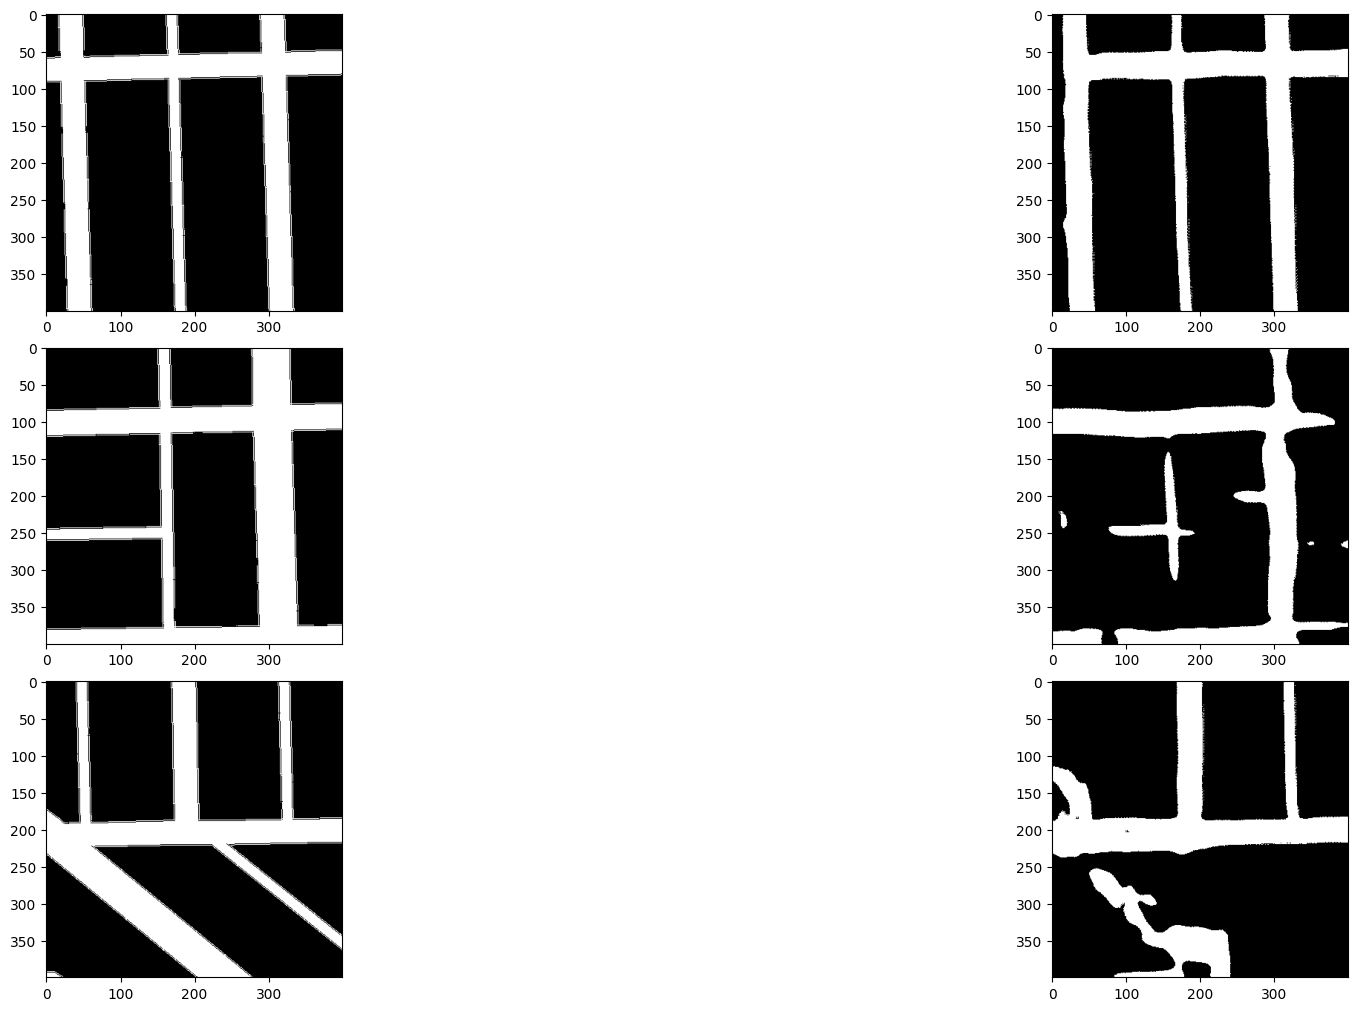

In [15]:
# Visualise groundtruth segmentation map and predicted segmentation map
# Sample first three images to visualise
fig, axs = plt.subplots(3, 2, constrained_layout = True)

axs[0][0].imshow(val_gts[2], cmap = 'gray')
axs[0][1].imshow(val_outputs[2], cmap = 'gray')

axs[1][0].imshow(val_gts[4], cmap = 'gray')
axs[1][1].imshow(val_outputs[4], cmap = 'gray')

axs[2][0].imshow(val_gts[8], cmap = 'gray')
axs[2][1].imshow(val_outputs[8], cmap = 'gray')